In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
FORECAST = 5
LAG = 12
EPS = 120
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
dset = LocalRoute(SROUTE, 'train', 32, lag=LAG).generator()
evalset = LocalRoute(SROUTE, 'test', 32, lag=LAG).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.23s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
Locals dataset: test
 [*] Loaded routes: 1 (0.24s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156


In [7]:
from models.spatial.RNN import RNN

In [8]:
model = RNN(forecast=FORECAST, hidden_size=512, deep=False, lag=LAG).to(device)
model.device = device

In [9]:
criterion, opt, sch = model.params(lr=0.001)

In [11]:
model.load_state_dict(torch.load('checkpoints/rnn_spatial.pth'))
evaluate(evalset, model, criterion)

Eval loss: 5.371843090699035


In [9]:
losses = []
eval_losses = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_losses.append(evaluate(evalset, model, criterion, result=True))
#     torch.save(model.state_dict(), 'checkpoints/%s_e%d.pth' % (model.name, eii+1))
    sys.stdout.flush()
    sch.step()

[1/120 : 6629/6629] - L2.15        
Eval loss: 6.5156861342945875
[2/120 : 6629/6629] - L10.26      
Eval loss: 6.221901337787205
[3/120 : 6629/6629] - L15.95      
Eval loss: 6.050538741812414
[4/120 : 6629/6629] - L1.55       
Eval loss: 5.918093475988325
[5/120 : 6629/6629] - L30.59      
Eval loss: 5.861442913814467
[6/120 : 6629/6629] - L2.07       
Eval loss: 5.753445768918918
[7/120 : 6629/6629] - L1.93        
Eval loss: 5.691421965099111
[8/120 : 6629/6629] - L1.54       
Eval loss: 5.642552088946104
[9/120 : 6629/6629] - L1.70       
Eval loss: 5.624344572576941
[10/120 : 6629/6629] - L3.61        
Eval loss: 5.572319741227797
[11/120 : 6629/6629] - L9.83       
Eval loss: 5.547324795580032
[12/120 : 6629/6629] - L1.96       
Eval loss: 5.524144439140753
[13/120 : 6629/6629] - L8.21       
Eval loss: 5.4944655179065105
[14/120 : 6629/6629] - L1.28       
Eval loss: 5.481225375314148
[15/120 : 6629/6629] - L1.52       
Eval loss: 5.4720793972362065
[16/120 : 6629/6629] - L1.55

Process Process-250:
Process Process-248:
Process Process-251:
Process Process-249:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-247:
Traceback (most recent call last):
Process Process-252:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._t

KeyboardInterrupt: 

In [17]:
# torch.save(model.state_dict(), 'checkpoints/rnn_spatial.pth')

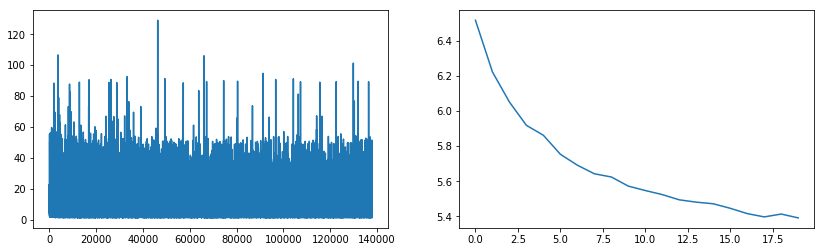

In [11]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.subplot(1, 2, 2)
plt.plot(eval_losses)
plt.show();plt.close()

2047


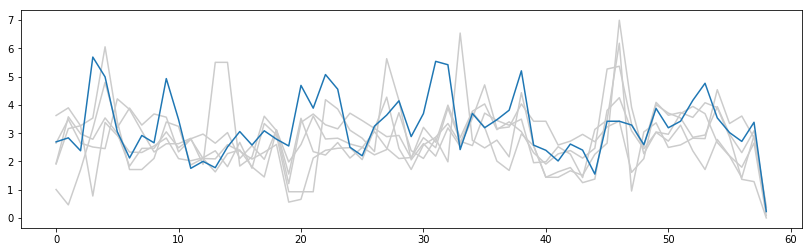

In [15]:
data = history_byname(SROUTE)

sample = data[int(TSTEPS*0.8):]
inds, integs = high_integ(sample[LAG:])
inds += LAG
print(inds[0])
sample = sample[inds[0]-LAG:inds[0]]
for jj, ii in zip(*np.where(np.isnan(sample))):
    sample[jj, ii] = sample[jj-1, ii]
# sample = hist_smooth(sample)
show_context(sample)

In [16]:
preds = []
for bi in range(10, sample.shape[1]+1):
    hist = sample[:, bi-10:bi].T
    Xs = np.expand_dims(hist, 1)
    Xs = torch.from_numpy(Xs).to(device).float()
    seqs = list(map(lambda vec: vec.squeeze(0), torch.split(Xs, 1)))
    seqs = list(reversed(seqs))

    yout = model(seqs)
    preds.append(tonpy(yout))

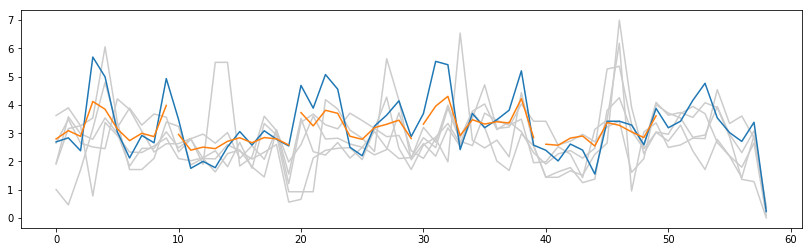

In [17]:
show_context(sample, draw=False)
for bi in range(10, sample.shape[1]+1, 10):
    ylast = np.flip(preds[bi-10][:, 0, -1])
    xpos = list(range(bi-10, bi))
    plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()

In [34]:
casts = []
for bi in range(20, sample.shape[1]+1):
    hist = sample[:, bi-10:bi].T
    Xs = np.expand_dims(hist, 1)
    Xs = torch.from_numpy(Xs).to(device).float()
    seqs = list(map(lambda vec: vec.squeeze(0), torch.split(Xs, 1)))
    seqs = list(reversed(seqs))

    __yout, last_hidden = model(seqs, dump=True)
    yout = tonpy(__yout)
    casted = []
    for _ in range(10):
        last_y = torch.from_numpy(yout[-1, :1, :]).to(device).float()
        seqs = list(torch.split(last_y, 1))
        yout, last_hidden = model(seqs, dump=True)
        yout = tonpy(yout)
        casted.append(yout)
    casted = np.concatenate(casted, 0)
    full = np.concatenate([tonpy(__yout), casted], 0)
#     print(full.shape)
    casts.append(full)

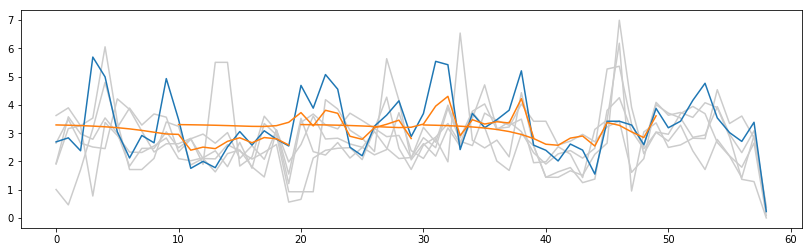

In [35]:
show_context(sample, draw=False)
for bi in range(20, sample.shape[1]+1, 10):
    ylast = np.flip(casts[bi-20][:, 0, -1])
    xpos = list(range(bi-20, bi))
    plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()